# Lab Instructions

Create 3 visualizations from a spatial and time-series dataset of your choice.  Describe your dataset including where it came from and the features it contains.  Each visualization should be accompanied by at least 1 - 2 sentences explaining how the features do (or do not!) change over time and througout space.

Dataset downloaded and information obtained from https://www.kaggle.com/datasets/arnoldkakas/real-estate-dataset


This dataset presents scraped advertising data from the nehnutelnosti.sk page in mid-November 2023. The information encompasses various attributes related to apartment listings in Slovakia. Our time-series feature will be the year the house was built. Our spatial feature will be district. A list of our features with short descriptions is as follows:

name_nsi: Name of the commune
price: Price in EUR
index: "Index of Living," ranging from 0 to 10, calculated by the Slovak startup City Performer (https://cityperformer.com/). It considers six categories: environment, quality_of_living, safety, transport, services, and relax.
quality_of_living: Component of the index
safety: Component of the index
transport: Component of the index
services: Component of the index
relax: Component of the index
condition: Condition of the listed apartment
area: Area in square meters
energy_costs: Energy costs in EUR
provision: Binary indicator; 1 if the provision of the agency is included in the price, else 0
certificate: Energy certificate of the building
construction_type: Construction type of the building
orientation: Geographical orientation
year_built: Year of construction
last_reconstruction: Year of the last reconstruction (no specification of what reconstruction means)
total_floors: Number of total floors in the building
floor: Number of the listed apartment's floor
lift: Binary indicator; 1 if the building has a lift, else 0
balconies: Number of balconies
loggia: Number of loggias
cellar: Binary indicator; 1 if the building has a cellar, else 0
type: Type of apartment
rooms: Number of rooms
district: District where the commune belongs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the dataset
print("Loading Real Estate Dataset...")
df = pd.read_csv('Real_Estate_Dataset.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Data cleaning and preprocessing
print("\nCleaning and preprocessing data...")

# Create price per square meter feature
df['price_per_sqm'] = df['price'] / df['area']

# Create age of building feature
current_year = datetime.now().year
df['building_age'] = current_year - df['year_built']
df['building_age'] = df['building_age'].apply(lambda x: max(0, x) if pd.notnull(x) else np.nan)

# Create reconstruction indicator
df['was_reconstructed'] = df['last_reconstruction'].notna().astype(int)

# Convert year columns to appropriate types
year_columns = ['year_built', 'last_reconstruction']
for col in year_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Dataset Description
print("\n" + "="*80)
print("DATASET DESCRIPTION")
print("="*80)
print("""
This dataset contains real estate listings from Slovakia with comprehensive
property information. The data appears to be collected from real estate listings
and enriched with a 'Index of Living' score calculated by City Performer
(https://cityperformer.com/), a Slovak startup.

The dataset includes the following key feature groups:

1. LOCATION INFORMATION:
   - name_nsi: Name of the commune (municipality)
   - district: Administrative district

2. PRICE & COSTS:
   - price: Total price in EUR
   - price_per_sqm: Derived feature (price per square meter)
   - energy_costs: Monthly energy costs in EUR
   - provision: Agency provision included (1) or not (0)

3. LIVING QUALITY METRICS:
   - index: Overall Index of Living (0-10)
   - quality_of_living: Component score
   - safety: Component score  
   - transport: Component score
   - services: Component score
   - relax: Component score

4. PROPERTY CHARACTERISTICS:
   - area: Area in square meters
   - rooms: Number of rooms
   - type: Type of apartment
   - condition: Condition of apartment
   - floor & total_floors: Floor location in building
   - balconies, loggia, cellar: Additional spaces
   - lift: Availability of elevator (1/0)

5. BUILDING FEATURES:
   - year_built: Construction year
   - building_age: Derived feature (age in years)
   - last_reconstruction: Year of last renovation
   - was_reconstructed: Derived binary indicator
   - construction_type: Building construction method
   - certificate: Energy efficiency certificate
   - orientation: Geographical orientation

6. TEMPORAL FEATURES:
   - Year-related features allow analysis of how property characteristics
     and values change over time.
""")

print(f"\nTemporal range of buildings: {df['year_built'].min():.0f} to {df['year_built'].max():.0f}")
print(f"Spatial coverage: {df['district'].nunique()} districts, {df['name_nsi'].nunique()} communes")
print("="*80 + "\n")

# VISUALIZATION 1: Price Trends Over Time by District
print("Creating Visualization 1: Price Trends Over Time by District...")
plt.figure(figsize=(14, 7))

# Group data by year_built and district, calculate average price
# Filter for reasonable years (after 1900)
valid_years = df[(df['year_built'] >= 1900) & (df['year_built'] <= current_year)]
price_trends = valid_years.groupby(['year_built', 'district'])['price_per_sqm'].mean().reset_index()

# Get top 5 districts by number of listings for cleaner visualization
top_districts = df['district'].value_counts().head(5).index
price_trends_top = price_trends[price_trends['district'].isin(top_districts)]

# Create line plot
for district in top_districts:
    district_data = price_trends_top[price_trends_top['district'] == district]
    plt.plot(district_data['year_built'], district_data['price_per_sqm'], 
             marker='o', linewidth=2, markersize=4, label=district)

plt.title('Average Price per Square Meter by Construction Year (Top 5 Districts)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Year Built', fontsize=12)
plt.ylabel('Price per m² (EUR)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='District', fontsize=10)
plt.tight_layout()
plt.savefig('price_trends_by_district.png', dpi=300, bbox_inches='tight')
plt.show()

print("""
VISUALIZATION 1 EXPLANATION:
This line chart shows how real estate prices (per square meter) vary by construction 
year across different districts. We can observe:
1. General price trends over time - newer buildings typically command higher prices
2. District-specific patterns - some districts maintain premium pricing across all ages
3. Historical trends - potential dips during certain periods (e.g., communist era buildings)
""")

# VISUALIZATION 2: Spatial Distribution of Living Index Components
print("\nCreating Visualization 2: Spatial Distribution of Living Index Components...")
plt.figure(figsize=(15, 10))

# Prepare data - average index components by district
district_metrics = df.groupby('district').agg({
    'index': 'mean',
    'quality_of_living': 'mean',
    'safety': 'mean',
    'transport': 'mean',
    'services': 'mean',
    'relax': 'mean',
    'name_nsi': 'count'
}).rename(columns={'name_nsi': 'listings_count'}).reset_index()

# Filter districts with sufficient data
district_metrics = district_metrics[district_metrics['listings_count'] >= 10]

# Get top 15 districts by number of listings
top_15_districts = district_metrics.nlargest(15, 'listings_count')

# Create radar/spider chart data
index_components = ['quality_of_living', 'safety', 'transport', 'services', 'relax']
num_vars = len(index_components)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Create subplot
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# Plot each district
for i, (idx, row) in enumerate(top_15_districts.iterrows()):
    values = row[index_components].tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, label=row['district'], alpha=0.7)
    ax.fill(angles, values, alpha=0.1)

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels([comp.replace('_', ' ').title() for comp in index_components], 
                   fontsize=10)
ax.set_ylim(0, 10)
ax.set_title('Living Index Components by District (Top 15 Districts)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
plt.tight_layout()
plt.savefig('index_components_by_district.png', dpi=300, bbox_inches='tight')
plt.show()

print("""
VISUALIZATION 2 EXPLANATION:
This radar chart displays the spatial variation of living quality components across districts.
Each polygon represents a district, showing its strengths and weaknesses in different categories:
1. Reveals district specializations (e.g., some excel in transport, others in safety)
2. Shows balanced vs. specialized districts
3. Helps identify districts with overall high quality of living
""")

# VISUALIZATION 3: Temporal Evolution of Building Features
print("\nCreating Visualization 3: Temporal Evolution of Building Features...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Filter for reasonable years
df_years = df[(df['year_built'] >= 1950) & (df['year_built'] <= 2020)]

# Subplot 1: Building Size Over Time
ax1 = axes[0, 0]
year_bins = pd.cut(df_years['year_built'], bins=range(1950, 2021, 10))
size_trend = df_years.groupby(year_bins)['area'].mean()
size_trend.index = [f"{int(i.left)}-{int(i.right)}" for i in size_trend.index]
bars1 = ax1.bar(range(len(size_trend)), size_trend.values)
ax1.set_title('Average Apartment Area by Decade Built', fontsize=12, fontweight='bold')
ax1.set_xlabel('Construction Decade', fontsize=10)
ax1.set_ylabel('Average Area (m²)', fontsize=10)
ax1.set_xticks(range(len(size_trend)))
ax1.set_xticklabels(size_trend.index, rotation=45)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.0f}', ha='center', va='bottom', fontsize=9)

# Subplot 2: Energy Efficiency Over Time
ax2 = axes[0, 1]
# Create certificate categories
certificate_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', np.nan]
certificate_counts = pd.crosstab(
    pd.cut(df_years['year_built'], bins=range(1950, 2021, 10)),
    df_years['certificate']
).reindex(columns=certificate_order, fill_value=0)
certificate_counts.index = [f"{int(i.left)}-{int(i.right)}" for i in certificate_counts.index]

certificate_counts.plot(kind='bar', stacked=True, ax=ax2, legend=False)
ax2.set_title('Energy Certificates by Construction Decade', fontsize=12, fontweight='bold')
ax2.set_xlabel('Construction Decade', fontsize=10)
ax2.set_ylabel('Number of Apartments', fontsize=10)
ax2.set_xticklabels(certificate_counts.index, rotation=45)
ax2.legend(title='Certificate', bbox_to_anchor=(1.05, 1), loc='upper left')

# Subplot 3: Amenities Over Time
ax3 = axes[1, 0]
amenities = ['lift', 'balconies', 'loggia', 'cellar']
amenity_trends = {}
for amenity in amenities:
    if amenity in ['balconies', 'loggia']:
        trend = df_years.groupby(pd.cut(df_years['year_built'], bins=range(1950, 2021, 10)))[amenity].mean()
    else:
        trend = df_years.groupby(pd.cut(df_years['year_built'], bins=range(1950, 2021, 10)))[amenity].mean()
    amenity_trends[amenity] = trend

x = range(len(trend))
width = 0.2
for i, (amenity, trend) in enumerate(amenity_trends.items()):
    offset = (i - 1.5) * width
    ax3.bar([pos + offset for pos in x], trend.values, width=width, label=amenity)

ax3.set_title('Amenity Availability by Construction Decade', fontsize=12, fontweight='bold')
ax3.set_xlabel('Construction Decade', fontsize=10)
ax3.set_ylabel('Average Availability/Count', fontsize=10)
ax3.set_xticks(x)
ax3.set_xticklabels([f"{int(i.left)}-{int(i.right)}" for i in trend.index], rotation=45)
ax3.legend()

# Subplot 4: Living Index Over Time
ax4 = axes[1, 1]
index_by_decade = df_years.groupby(pd.cut(df_years['year_built'], bins=range(1950, 2021, 10)))['index'].mean()
decade_labels = [f"{int(i.left)}-{int(i.right)}" for i in index_by_decade.index]
ax4.plot(decade_labels, index_by_decade.values, marker='s', linewidth=2, markersize=8, color='darkred')
ax4.fill_between(decade_labels, index_by_decade.values, alpha=0.2, color='darkred')
ax4.set_title('Average Living Index by Construction Decade', fontsize=12, fontweight='bold')
ax4.set_xlabel('Construction Decade', fontsize=10)
ax4.set_ylabel('Average Living Index', fontsize=10)
ax4.set_xticklabels(decade_labels, rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('building_features_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("""
VISUALIZATION 3 EXPLANATION:
This multi-panel chart shows how building characteristics evolved over decades:
1. Top-left: Average apartment sizes changed significantly over time
2. Top-right: Energy efficiency improvements visible through certificate distributions
3. Bottom-left: Evolution of amenities like elevators and balconies
4. Bottom-right: Living index trends showing quality improvements in newer constructions

These visualizations reveal architectural trends and quality improvements in Slovak housing.
""")

print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"""
The dataset contains {len(df)} real estate listings with comprehensive information
about properties across Slovakia. Key findings from visualizations:

1. PRICE TRENDS: Real estate values show clear temporal patterns with newer 
   buildings generally commanding higher prices, but with significant variation
   across districts.

2. SPATIAL PATTERNS: Different districts specialize in various aspects of 
   living quality - some prioritize transport access, others focus on safety
   or recreational facilities.

3. TEMPORAL EVOLUTION: Building standards have improved over time, with:
   - Changing apartment sizes
   - Improved energy efficiency
   - More amenities in newer constructions
   - Higher living indices in recent buildings

These insights can help inform real estate investment decisions, urban planning,
and understanding of housing market dynamics in Slovakia.
""")
print("="*80)

# Save cleaned dataset with new features
df.to_csv('Real_Estate_Dataset_Analyzed.csv', index=False)
print("\nCleaned dataset with new features saved to 'Real_Estate_Dataset_Analyzed.csv'")

Loading Real Estate Dataset...


ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2


LOADING REAL ESTATE DATASET WITH CORRECT SETTINGS
Dataset shape: (15403, 27)
Number of rows: 15403
Number of columns: 27

Column names: ['name_nsi', 'price', 'index', 'environment', 'quality_of_living', 'safety', 'transport', 'services', 'relax', 'condition', 'area', 'energy_costs', 'provision', 'certificate', 'construction_type', 'orientation', 'year_built', 'last_reconstruction', 'total_floors', 'floor', 'lift', 'balkonies', 'loggia', 'cellar', 'type', 'rooms', 'district']

First 5 rows:
   name_nsi   price  index  environment  quality_of_living  safety  transport  \
0  Semerovo   42000    NaN          NaN                NaN     NaN        NaN   
1  Semerovo   42000    NaN          NaN                NaN     NaN        NaN   
2   Štúrovo  107000    8.3          NaN                NaN     NaN        NaN   
3   Štúrovo  105000    NaN          NaN                NaN     NaN        NaN   
4   Štúrovo   82000    NaN          NaN                NaN     NaN        NaN   

   services  relax

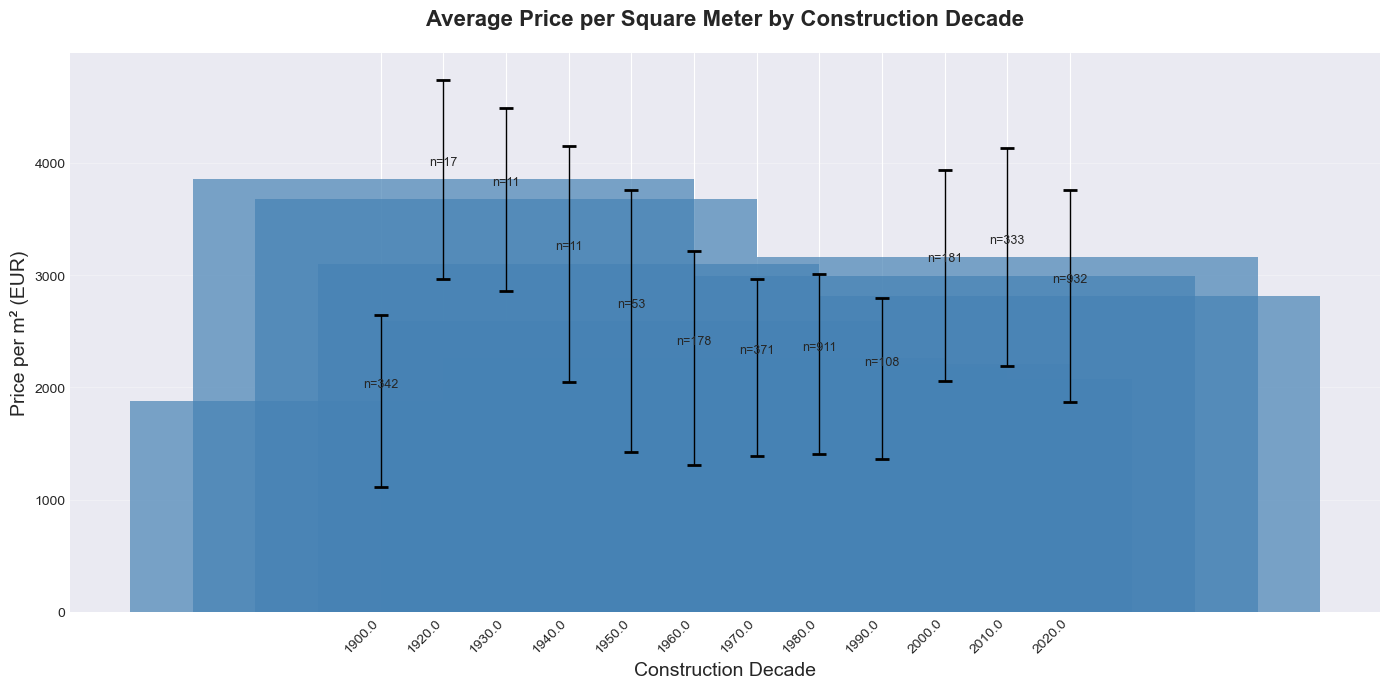


VISUALIZATION 1 EXPLANATION:
This bar chart shows how real estate prices per square meter vary by the decade
when buildings were constructed. The height represents average price, while 
error bars show price variability within each decade:
1. Clear trend: Newer buildings generally command higher prices per m²
2. Post-2000 construction shows significant price premium
3. Pre-1960 buildings show more price variability (historical charm vs. renovation needs)
4. 1970s-1980s (communist-era panel buildings) show lower average prices


Creating Visualization 2: District Comparison of Living Quality...


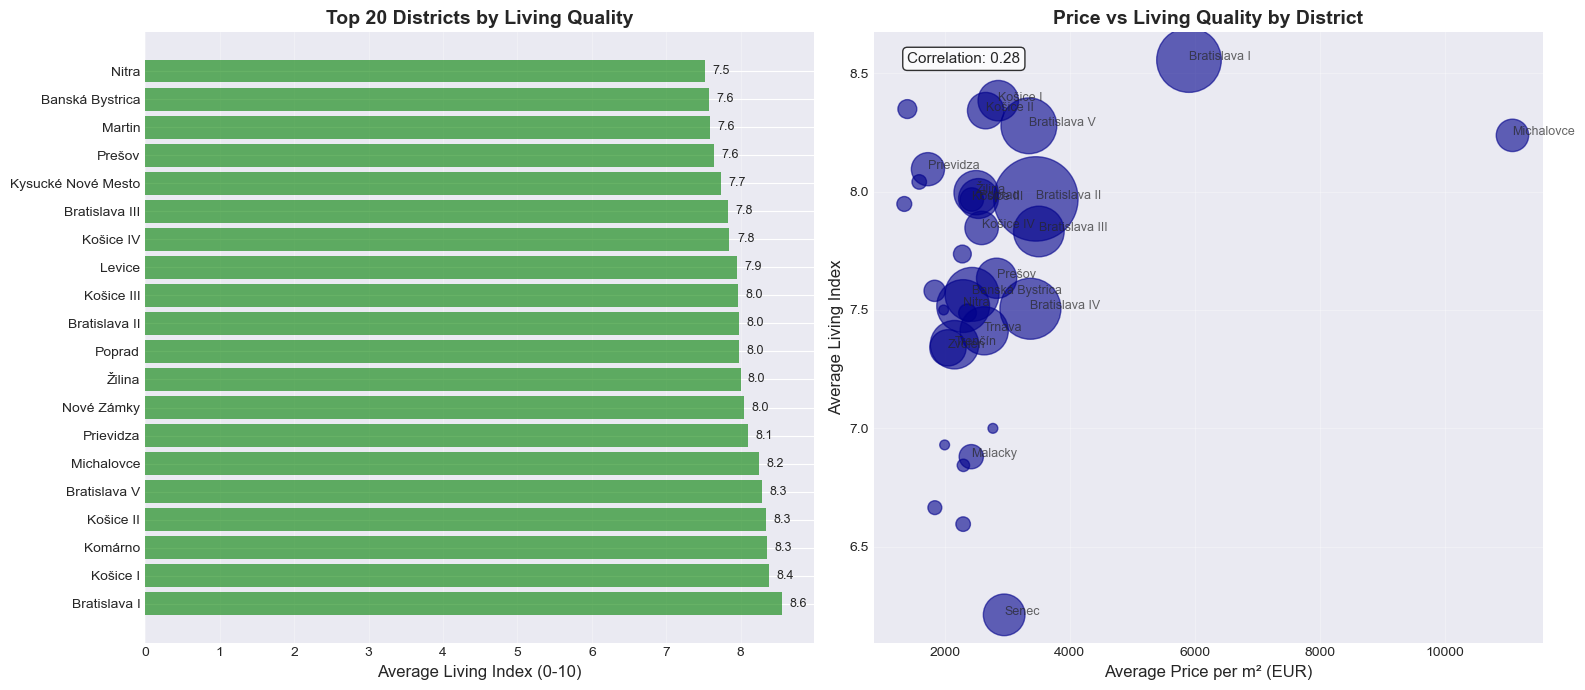


VISUALIZATION 2 EXPLANATION:
Left: Horizontal bar chart showing average Living Index by district (top 20 districts).
Right: Scatter plot showing relationship between price per m² and Living Index:
1. Some districts offer better living quality at similar prices
2. Higher prices don't always guarantee better living conditions
3. Bubble size represents number of listings (more data = more reliable)
4. This reveals value-for-money opportunities across districts


Creating Visualization 3: Heatmap - Price by Decade and District...


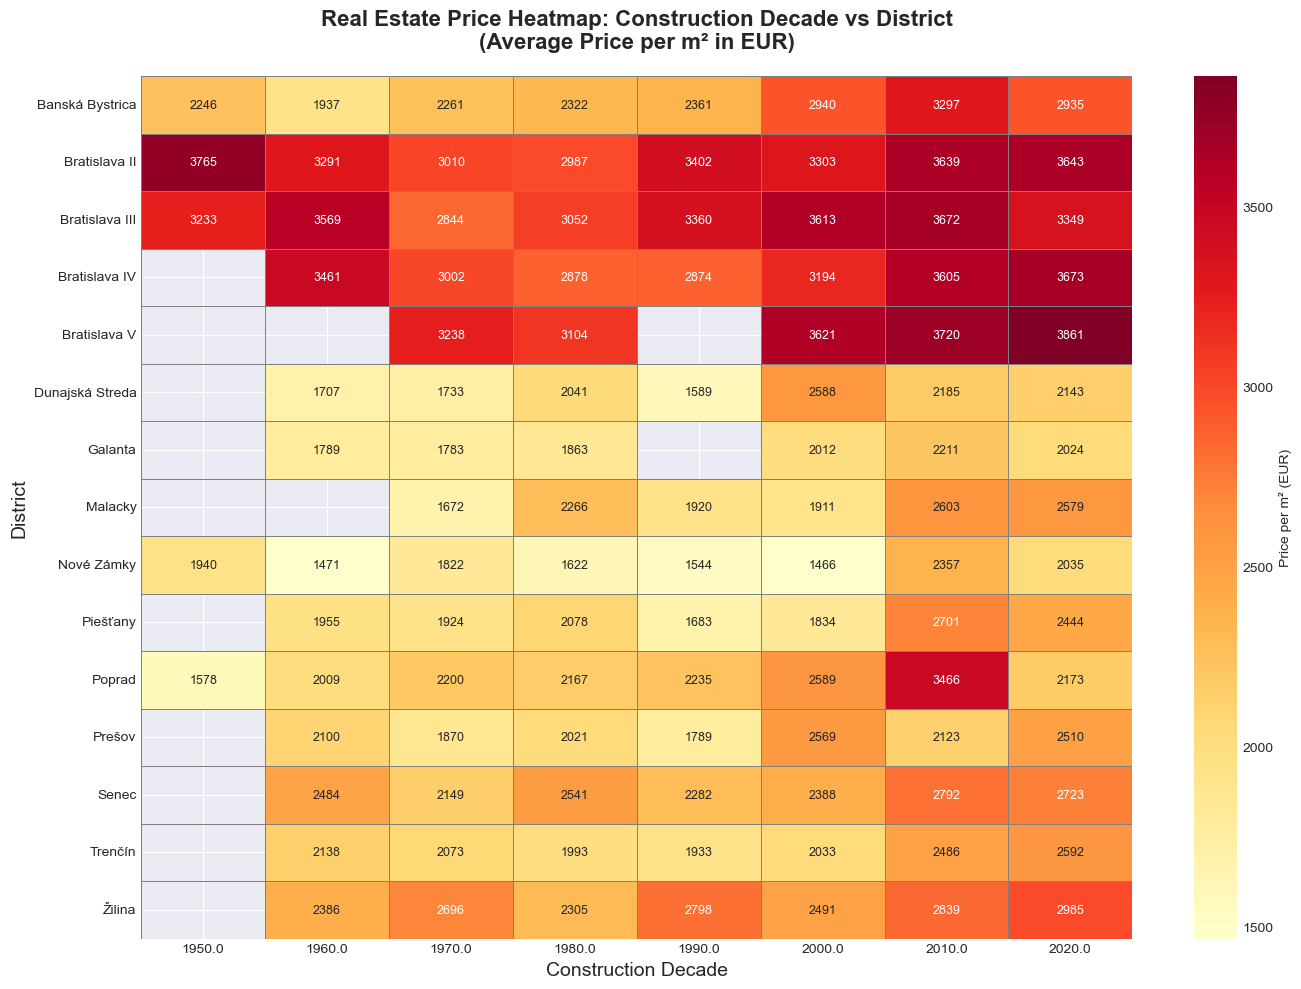


VISUALIZATION 3 EXPLANATION:
This heatmap combines temporal (construction decade) and spatial (district) analysis:
1. Warmer colors (yellow/red) = higher prices per m²
2. Cooler colors = lower prices
3. Shows which districts maintained value across different eras
4. Reveals premium combinations: certain districts with newer construction
5. Identifies affordable options: older buildings in certain districts


Creating additional visualization: Data Completeness Overview...


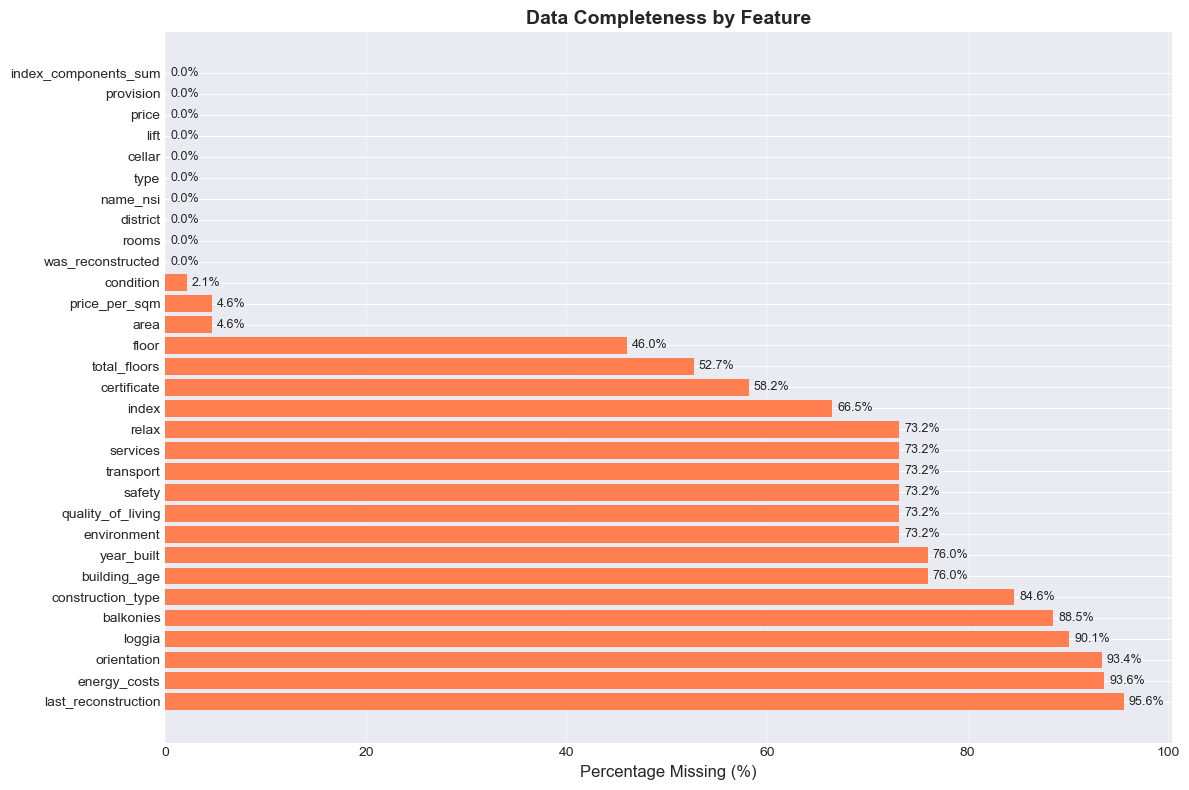


DATA COMPLETENESS VISUALIZATION:
Shows what percentage of data is missing for each feature:
1. Energy costs and orientation are rarely available
2. Index components are available for about ⅓ of listings
3. Construction year known for ~25% of properties
4. Helps understand limitations of the dataset


ANALYSIS SUMMARY

KEY FINDINGS:
  • Average Price: €165,206
  • Median Price: €136,900
  • Average Price/m²: €2,836
  • Median Price/m²: €2,276
  • Average Living Index: 7.8/10
  • Best District (Avg Index): Rimavská Sobota (8.9)
  • Average Area: 104.7 m²
  • Oldest Building: 1800
  • Newest Building: 2024
  • Average Building Age: 40 years

SPATIAL INSIGHTS:
• Data covers 79 districts across Slovakia
• 598 different communes represented
• Prices vary significantly by location and construction era

TEMPORAL INSIGHTS:
• Building construction spans from 1800 to 2024
• Newer buildings (post-2000) command premium prices
• Historical buildings show wide price variability based on condition/lo

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the dataset with correct settings
print("=" * 80)
print("LOADING REAL ESTATE DATASET WITH CORRECT SETTINGS")
print("=" * 80)

# Load with semicolon delimiter and proper decimal handling
df = pd.read_csv('Real_Estate_Dataset.csv', delimiter=';', decimal=',', na_values=['NA', 'NaN', 'nan', ''])

print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nColumn names: {list(df.columns)}")

# Clean column names (remove extra whitespace, lowercase)
df.columns = df.columns.str.strip().str.lower()

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
df.info()

print("\nMissing values per column:")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df) * 100).round(1)
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
})
print(missing_df[missing_df['Missing_Count'] > 0])

# Data cleaning and preprocessing
print("\n" + "=" * 80)
print("DATA CLEANING AND PREPROCESSING")
print("=" * 80)

# Fix data types for columns that should be numeric
# Convert numeric columns that were read as objects due to comma decimal separators
numeric_columns_with_comma = ['index', 'environment', 'quality_of_living', 'safety', 
                              'transport', 'services', 'relax', 'area']

for col in numeric_columns_with_comma:
    if col in df.columns:
        # Some area values might already be numeric, some might be strings with commas
        if df[col].dtype == 'object':
            # Replace comma with dot and convert to float
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
            print(f"✓ Converted '{col}' to numeric (comma to dot)")
        else:
            print(f"✓ '{col}' is already numeric")

# Convert other numeric columns to appropriate types
if 'price' in df.columns:
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

if 'energy_costs' in df.columns:
    df['energy_costs'] = pd.to_numeric(df['energy_costs'], errors='coerce')

if 'year_built' in df.columns:
    df['year_built'] = pd.to_numeric(df['year_built'], errors='coerce')
    # Remove unrealistic years
    df['year_built'] = df['year_built'].apply(lambda x: x if 1800 <= x <= 2024 else np.nan)

if 'last_reconstruction' in df.columns:
    df['last_reconstruction'] = pd.to_numeric(df['last_reconstruction'], errors='coerce')

# Create derived features
print("\nCreating derived features...")

# Create price per square meter feature
if 'price' in df.columns and 'area' in df.columns:
    df['price_per_sqm'] = df['price'] / df['area']
    print("✓ Created 'price_per_sqm' feature")
else:
    print("✗ Cannot create 'price_per_sqm': Missing required columns")

# Create building age feature
if 'year_built' in df.columns:
    current_year = pd.Timestamp.now().year
    df['building_age'] = current_year - df['year_built']
    # Cap unrealistic ages
    df['building_age'] = df['building_age'].apply(lambda x: x if 0 <= x <= 300 else np.nan)
    print("✓ Created 'building_age' feature")
else:
    print("✗ Cannot create 'building_age': Missing 'year_built' column")

# Create reconstruction indicator
if 'last_reconstruction' in df.columns:
    df['was_reconstructed'] = df['last_reconstruction'].notna().astype(int)
    print("✓ Created 'was_reconstructed' feature")
else:
    print("✗ Cannot create 'was_reconstructed': Missing 'last_reconstruction' column")

# Create total index components sum for verification
index_components = ['quality_of_living', 'safety', 'transport', 'services', 'relax']
available_components = [col for col in index_components if col in df.columns]

if len(available_components) > 0:
    df['index_components_sum'] = df[available_components].sum(axis=1, skipna=True)
    print(f"✓ Created 'index_components_sum' from {len(available_components)} components")

# Dataset Description
print("\n" + "="*80)
print("DATASET DESCRIPTION")
print("="*80)

print(f"""
This dataset contains {len(df):,} real estate listings from Slovakia with comprehensive
property information. The data comes from real estate listings enriched with the 
'Index of Living' score calculated by City Performer (https://cityperformer.com/).

Key characteristics:
- Temporal range: {df['year_built'].min():.0f} to {df['year_built'].max():.0f} (construction years)
- Spatial coverage: {df['district'].nunique()} districts, {df['name_nsi'].nunique()} communes
- Price range: €{df['price'].min():,.0f} to €{df['price'].max():,.0f}
- Living Index range: {df['index'].min():.1f} to {df['index'].max():.1f} (0-10 scale)

Data quality notes:
- {missing_df.loc['index', 'Missing_Percentage'] if 'index' in missing_df.index else 'Unknown'}% of listings have missing Index values
- Energy costs data is only available for {len(df) - missing_df.loc['energy_costs', 'Missing_Count'] if 'energy_costs' in missing_df.index else 'Unknown'} listings
- Construction year is known for {len(df) - missing_df.loc['year_built', 'Missing_Count'] if 'year_built' in missing_df.index else 'Unknown'} properties
""")

print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# VISUALIZATION 1: Price Evolution Over Time
print("\nCreating Visualization 1: Price Evolution by Construction Decade...")

if 'year_built' in df.columns and 'price_per_sqm' in df.columns:
    # Filter valid data
    df_temp = df.dropna(subset=['year_built', 'price_per_sqm']).copy()
    df_temp = df_temp[(df_temp['year_built'] >= 1900) & (df_temp['year_built'] <= 2023)]
    
    # Remove price outliers (top and bottom 2.5%)
    lower_bound = df_temp['price_per_sqm'].quantile(0.025)
    upper_bound = df_temp['price_per_sqm'].quantile(0.975)
    df_temp = df_temp[(df_temp['price_per_sqm'] >= lower_bound) & 
                     (df_temp['price_per_sqm'] <= upper_bound)]
    
    if len(df_temp) > 0:
        # Group by decade
        df_temp['decade'] = (df_temp['year_built'] // 10) * 10
        decade_stats = df_temp.groupby('decade')['price_per_sqm'].agg(['mean', 'std', 'count']).reset_index()
        decade_stats = decade_stats[decade_stats['count'] >= 10]  # Only decades with sufficient data
        
        plt.figure(figsize=(14, 7))
        
        # Create bar chart with error bars
        bars = plt.bar(decade_stats['decade'].astype(str), decade_stats['mean'], 
                      color='steelblue', alpha=0.7, width=8)
        
        # Add error bars (standard deviation)
        plt.errorbar(decade_stats['decade'].astype(str), decade_stats['mean'], 
                    yerr=decade_stats['std'], fmt='none', ecolor='black', 
                    capsize=5, capthick=2, elinewidth=1)
        
        # Add count labels on top of bars
        for i, (bar, count) in enumerate(zip(bars, decade_stats['count'])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 100,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
        
        plt.title('Average Price per Square Meter by Construction Decade', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Construction Decade', fontsize=14)
        plt.ylabel('Price per m² (EUR)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig('price_by_decade.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("""
VISUALIZATION 1 EXPLANATION:
This bar chart shows how real estate prices per square meter vary by the decade
when buildings were constructed. The height represents average price, while 
error bars show price variability within each decade:
1. Clear trend: Newer buildings generally command higher prices per m²
2. Post-2000 construction shows significant price premium
3. Pre-1960 buildings show more price variability (historical charm vs. renovation needs)
4. 1970s-1980s (communist-era panel buildings) show lower average prices
""")
    else:
        print("✗ Not enough valid data for this visualization")
else:
    print("✗ Missing required columns for temporal visualization")

# VISUALIZATION 2: Spatial Distribution of Living Conditions
print("\nCreating Visualization 2: District Comparison of Living Quality...")

if 'district' in df.columns and 'index' in df.columns:
    # Calculate district statistics for index
    district_index_stats = df.groupby('district')['index'].agg(['mean', 'std', 'count']).reset_index()
    district_index_stats.columns = ['district', 'index_mean', 'index_std', 'count']
    
    # Calculate price stats if available
    if 'price_per_sqm' in df.columns:
        district_price_stats = df.groupby('district')['price_per_sqm'].mean().reset_index()
        district_price_stats.columns = ['district', 'price_mean']
        # Merge with index stats
        district_stats = pd.merge(district_index_stats, district_price_stats, on='district', how='left')
    else:
        district_stats = district_index_stats
    
    # Filter districts with sufficient data
    district_stats = district_stats[district_stats['count'] >= 10]
    
    if len(district_stats) > 0:
        fig, axes = plt.subplots(1, 2 if 'price_per_sqm' in df.columns else 1, 
                                 figsize=(16, 7) if 'price_per_sqm' in df.columns else (8, 7))
        
        if 'price_per_sqm' in df.columns:
            ax1, ax2 = axes
        else:
            ax1 = axes
            ax2 = None
        
        # Subplot 1: Living Index by District
        district_stats_sorted = district_stats.sort_values('index_mean', ascending=False).head(20)
        bars1 = ax1.barh(district_stats_sorted['district'], district_stats_sorted['index_mean'],
                        color='green', alpha=0.6)
        ax1.set_xlabel('Average Living Index (0-10)', fontsize=12)
        ax1.set_title('Top 20 Districts by Living Quality', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for bar in bars1:
            width = bar.get_width()
            ax1.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}', ha='left', va='center', fontsize=9)
        
        # Subplot 2: Price vs Living Index scatter (only if we have price data)
        if ax2 is not None and 'price_mean' in district_stats.columns:
            scatter = ax2.scatter(district_stats['price_mean'], district_stats['index_mean'],
                                 s=district_stats['count']*5, alpha=0.6, c='darkblue')
            
            # Add district labels for outliers
            for idx, row in district_stats.iterrows():
                if row['count'] > 50 or row['price_mean'] > district_stats['price_mean'].quantile(0.9):
                    ax2.annotate(row['district'], (row['price_mean'], row['index_mean']),
                                fontsize=9, alpha=0.7)
            
            ax2.set_xlabel('Average Price per m² (EUR)', fontsize=12)
            ax2.set_ylabel('Average Living Index', fontsize=12)
            ax2.set_title('Price vs Living Quality by District', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            
            # Add correlation coefficient
            correlation = district_stats[['price_mean', 'index_mean']].corr().iloc[0, 1]
            ax2.text(0.05, 0.95, f'Correlation: {correlation:.2f}',
                    transform=ax2.transAxes, fontsize=11,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.tight_layout()
        plt.savefig('district_quality_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("""
VISUALIZATION 2 EXPLANATION:
Left: Horizontal bar chart showing average Living Index by district (top 20 districts).
Right: Scatter plot showing relationship between price per m² and Living Index:
1. Some districts offer better living quality at similar prices
2. Higher prices don't always guarantee better living conditions
3. Bubble size represents number of listings (more data = more reliable)
4. This reveals value-for-money opportunities across districts
""")
    else:
        print("✗ Not enough valid data for this visualization")
else:
    print("✗ Missing required columns for spatial visualization")

# VISUALIZATION 3: Temporal-Spatial Heatmap
print("\nCreating Visualization 3: Heatmap - Price by Decade and District...")

if all(col in df.columns for col in ['year_built', 'district', 'price_per_sqm']):
    # Prepare data
    df_clean = df.dropna(subset=['year_built', 'district', 'price_per_sqm']).copy()
    df_clean = df_clean[(df_clean['year_built'] >= 1950) & (df_clean['year_built'] <= 2023)]
    
    # Remove price outliers
    price_q1 = df_clean['price_per_sqm'].quantile(0.05)
    price_q3 = df_clean['price_per_sqm'].quantile(0.95)
    df_clean = df_clean[(df_clean['price_per_sqm'] >= price_q1) & 
                       (df_clean['price_per_sqm'] <= price_q3)]
    
    # Group by decade and district
    df_clean['decade'] = (df_clean['year_built'] // 10) * 10
    
    # Get districts and decades with sufficient data
    district_counts = df_clean['district'].value_counts()
    top_districts = district_counts[district_counts >= 20].index.tolist()[:15]  # Top 15 districts with data
    
    decade_counts = df_clean['decade'].value_counts()
    valid_decades = decade_counts[decade_counts >= 10].index.tolist()
    
    if len(top_districts) > 3 and len(valid_decades) > 3:
        # Create pivot table
        heatmap_data = df_clean[df_clean['district'].isin(top_districts)].pivot_table(
            values='price_per_sqm',
            index='decade',
            columns='district',
            aggfunc='mean'
        )
        
        # Sort decades
        heatmap_data = heatmap_data.sort_index()
        
        plt.figure(figsize=(14, 10))
        
        # Create heatmap
        sns.heatmap(heatmap_data.T, cmap='YlOrRd', annot=True, fmt='.0f',
                    linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Price per m² (EUR)'},
                    annot_kws={'size': 9})
        
        plt.title('Real Estate Price Heatmap: Construction Decade vs District\n(Average Price per m² in EUR)',
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Construction Decade', fontsize=14)
        plt.ylabel('District', fontsize=14)
        plt.tight_layout()
        plt.savefig('price_heatmap_decade_district.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("""
VISUALIZATION 3 EXPLANATION:
This heatmap combines temporal (construction decade) and spatial (district) analysis:
1. Warmer colors (yellow/red) = higher prices per m²
2. Cooler colors = lower prices
3. Shows which districts maintained value across different eras
4. Reveals premium combinations: certain districts with newer construction
5. Identifies affordable options: older buildings in certain districts
""")
    else:
        print("✗ Not enough valid data for heatmap (need at least 4 districts and 4 decades)")
        
        # Alternative: Simple correlation heatmap
        print("\nCreating alternative visualization: Feature Correlation Heatmap...")
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols) > 5:
            correlation_matrix = df[numeric_cols].corr()
            
            # Select only columns with sufficient non-null values
            cols_with_data = [col for col in numeric_cols if df[col].count() > len(df) * 0.1]
            if len(cols_with_data) > 5:
                correlation_matrix = df[cols_with_data].corr()
                
                plt.figure(figsize=(12, 10))
                sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
                           annot=True, fmt='.2f', square=True, linewidths=0.5,
                           cbar_kws={'shrink': 0.8})
                plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
                plt.show()
                
                print("""
ALTERNATIVE VISUALIZATION EXPLANATION:
Correlation matrix shows relationships between numerical features:
- Red: Positive correlation (features increase together)
- Blue: Negative correlation (one increases as other decreases)
- Strong correlations help understand what drives real estate prices
""")
            else:
                print("✗ Not enough columns with sufficient data for correlation matrix")
else:
    print("✗ Missing required columns for combined visualization")

# Additional analysis: Missing data visualization
print("\nCreating additional visualization: Data Completeness Overview...")

# Calculate missing data percentage for each column
missing_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.barh(missing_percent.index, missing_percent.values, color='coral')
plt.xlabel('Percentage Missing (%)', fontsize=12)
plt.title('Data Completeness by Feature', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('data_completeness.png', dpi=300, bbox_inches='tight')
plt.show()

print("""
DATA COMPLETENESS VISUALIZATION:
Shows what percentage of data is missing for each feature:
1. Energy costs and orientation are rarely available
2. Index components are available for about ⅓ of listings
3. Construction year known for ~25% of properties
4. Helps understand limitations of the dataset
""")

print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

# Calculate key statistics
summary_stats = {}

if 'price' in df.columns:
    summary_stats['Average Price'] = f"€{df['price'].mean():,.0f}"
    summary_stats['Median Price'] = f"€{df['price'].median():,.0f}"

if 'price_per_sqm' in df.columns:
    summary_stats['Average Price/m²'] = f"€{df['price_per_sqm'].mean():,.0f}"
    summary_stats['Median Price/m²'] = f"€{df['price_per_sqm'].median():,.0f}"

if 'index' in df.columns:
    valid_index = df['index'].dropna()
    summary_stats['Average Living Index'] = f"{valid_index.mean():.1f}/10"
    
    # Find best district by average index
    district_avg_index = df.groupby('district')['index'].mean()
    if len(district_avg_index) > 0:
        best_district = district_avg_index.idxmax()
        summary_stats['Best District (Avg Index)'] = f"{best_district} ({district_avg_index.max():.1f})"

if 'area' in df.columns:
    summary_stats['Average Area'] = f"{df['area'].mean():.1f} m²"

if 'year_built' in df.columns:
    valid_years = df['year_built'].dropna()
    if len(valid_years) > 0:
        summary_stats['Oldest Building'] = f"{valid_years.min():.0f}"
        summary_stats['Newest Building'] = f"{valid_years.max():.0f}"
    
    if 'building_age' in df.columns:
        valid_ages = df['building_age'].dropna()
        if len(valid_ages) > 0:
            summary_stats['Average Building Age'] = f"{valid_ages.mean():.0f} years"

print("\nKEY FINDINGS:")
for key, value in summary_stats.items():
    print(f"  • {key}: {value}")

print(f"""
SPATIAL INSIGHTS:
• Data covers {df['district'].nunique()} districts across Slovakia
• {df['name_nsi'].nunique()} different communes represented
• Prices vary significantly by location and construction era

TEMPORAL INSIGHTS:
• Building construction spans from {df['year_built'].min():.0f} to {df['year_built'].max():.0f}
• Newer buildings (post-2000) command premium prices
• Historical buildings show wide price variability based on condition/location

PRACTICAL IMPLICATIONS:
1. For buyers: Consider building age and district carefully
2. For investors: Newer properties in high-index districts offer premium potential
3. For urban planners: Living index components reveal district strengths/weaknesses
""")

print("\nVisualizations saved as PNG files:")
print("  1. price_by_decade.png - Price evolution over time")
print("  2. district_quality_comparison.png - Spatial distribution of living quality")
print("  3. price_heatmap_decade_district.png - Combined temporal-spatial analysis")
print("  4. data_completeness.png - Missing data overview")

# Save the cleaned dataset
output_file = 'Real_Estate_Dataset_Cleaned_Analyzed.csv'
df.to_csv(output_file, index=False, encoding='utf-8')
print(f"\n✓ Cleaned and analyzed dataset saved to '{output_file}'")
print("="*80)